# Проект "Flat price prediction".


## Проект "flat_price_prediction" состоит из двух частей:
### 1. Парсинг сайта krisha.kz с целью извлечения датасета.
### 2. Построение модели для прогнозирования стоимости квартир.

## Часть 2: Построение модели.

In [1]:
import os
import numpy as np
import pandas as pd
import sys
import re
from datetime import datetime
from pprint import pprint

In [2]:
import ipython_exit as ie
import helper_v31102020 as utils

In [3]:
import locale
import copy

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

In [6]:
#Выставим опции pandas для удобства просмотра
pd.set_option('display.max_columns', 600)
pd.set_option('max_colwidth', 200)

In [7]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [8]:
RANDOM_SEED = 42

In [9]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

## 1. Загрузка данных

In [10]:
PATH_to_file = './data/'

In [11]:
lst_files = os.listdir(PATH_to_file)

In [12]:
data_all = []

for fl in lst_files:
    data = pd.read_csv(PATH_to_file + fl)
    data_all.append(data)

df = pd.concat(data_all)

In [13]:
df.sample()

,id,page,url,district,live_rooms,title,price,address,text_preview,owner,stats_city,ad_date,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,pars_date,flat.building,flat.floor,live.square,flat.renovation,flat.toilet,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,live.furniture,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,flat.priv_dorm,options_text,text
1403,665657227,71,https://krisha.kz/a/show/665657227,almaty-bostandykskij,1.0,"1-комнатная квартира, 33 м², 1/5 этаж",18000000,"Бостандыкский р-н, мкр Орбита-3, Мкр Орбита-3","панельный дом, 1978 г.п., жил. площадь 18 кв.м., кухня 6 кв.м., Продаем удобную 1-х комнатную квартиру в одном из лучших районов города, расположенную близко к парку первого Президента - идеальное...",Специалист,Алматы,9 мар.,0,0,0,0,0,0,14-03-2021 15:40:56,"панельный, 1978 г.п.",1 из 5,"33 м², жилая — 18 м², кухня — 6 м²",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,"Продаем удобную 1-х комнатную квартиру в одном из лучших районов города, расположенную близко к парку первого Президента - идеальное место для вечернего моциона, утренней пробежки и качественного ..."


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147029 entries, 0 to 3987
Data columns (total 39 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               147029 non-null  int64  
 1   page             147029 non-null  int64  
 2   url              147029 non-null  object 
 3   district         147029 non-null  object 
 4   live_rooms       147029 non-null  float64
 5   title            147029 non-null  object 
 6   price            147029 non-null  int64  
 7   address          147029 non-null  object 
 8   text_preview     147029 non-null  object 
 9   owner            147029 non-null  object 
 10  stats_city       147029 non-null  object 
 11  ad_date          147029 non-null  object 
 12  paid_hot         147029 non-null  int64  
 13  paid_up          147029 non-null  int64  
 14  paid_fast        147029 non-null  int64  
 15  paid_urgent      147029 non-null  int64  
 16  paid_turbo       147029 non-null  int64  
 17

<Axes: >

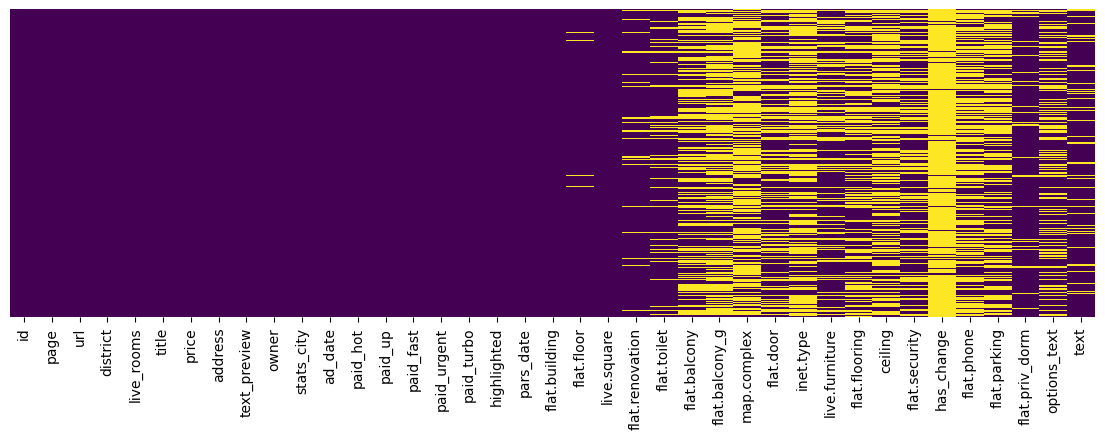

In [15]:
plt.figure(figsize=(14, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap = 'viridis')

Перед обработкой сохраним оригинальный датасет

In [16]:
data = copy.deepcopy(df)

### Устранение дублей

In [17]:
df.id.value_counts(ascending=True)[:3]

id
665357177    1
665738140    1
665740942    1
Name: count, dtype: int64

In [18]:
valuable_columns = list(df.columns)
valuable_columns.remove('id')
valuable_columns.remove('page')
valuable_columns.remove('url')
valuable_columns.remove('ad_date')
valuable_columns.remove('pars_date')
print(valuable_columns)

['district', 'live_rooms', 'title', 'price', 'address', 'text_preview', 'owner', 'stats_city', 'paid_hot', 'paid_up', 'paid_fast', 'paid_urgent', 'paid_turbo', 'highlighted', 'flat.building', 'flat.floor', 'live.square', 'flat.renovation', 'flat.toilet', 'flat.balcony', 'flat.balcony_g', 'map.complex', 'flat.door', 'inet.type', 'live.furniture', 'flat.flooring', 'ceiling', 'flat.security', 'has_change', 'flat.phone', 'flat.parking', 'flat.priv_dorm', 'options_text', 'text']


In [19]:
df.drop_duplicates(subset=valuable_columns, inplace=True, keep='last', ignore_index=True)

In [20]:
len(df)

92528

### Столько объявлений останется, если оставить только "значимые столбцы" и удалить дубли.

## 2. Обработка признаков

### Удаляем неинформативные признаки

In [21]:
df.drop(['id', 'page', 'url', 'pars_date', 'stats_city'], axis=1, inplace=True)

### "Закодируем" первую группу категориальных признаков без пропусков (Label Encoding)

In [22]:
cat_f_1 = ['district', 'owner']

In [23]:
for col in cat_f_1:
    print(col, df[col].nunique(), '\n', df[col].value_counts(), '\n')

district 8 
 district
almaty-bostandykskij    28676
almaty-aujezovskij      18990
almaty-almalinskij      18501
almaty-medeuskij        10231
almaty-alatauskij        5003
almaty-nauryzbajskiy     3983
almaty-zhetysuskij       3979
almaty-turksibskij       3165
Name: count, dtype: int64 

owner 7 
 owner
Специалист                54629
Хозяин недвижимости       22119
Проверенный специалист     9853
Проверенная компания       2977
Компания                   2877
Специалист оштрафован        49
На проверке                  24
Name: count, dtype: int64 



In [24]:
# Кодируем категориальные признаки
for col in cat_f_1:
    df[col] = df[col].astype('category').cat.codes

In [25]:
#Проверяем
for col in cat_f_1:
    print(col, df[col].nunique(), '\n', df[col].value_counts(), '\n')

district 8 
 district
3    28676
2    18990
1    18501
4    10231
0     5003
5     3983
7     3979
6     3165
Name: count, dtype: int64 

owner 7 
 owner
4    54629
6    22119
3     9853
2     2977
0     2877
5       49
1       24
Name: count, dtype: int64 



### Теперь из признаков live_rooms, title, flat.floor и live.square нужно получить количество комнат, площади, этаж, на котором находится квартира и количество этажей в доме. Также, будут полезны новые признаки, как Первый этаж, Последний этаж, Отношение площади к количеству комнат.

Определяем функции

In [26]:
def extract_live_rooms(str_title):
    return int(str_title.split(', ', 2)[0].split('-', 1)[0])

In [27]:
def extract_total_square(str_title):
    return float(str_title.split(', ', 2)[1].split(' м²', 1)[0])

In [28]:
def extract_total_square1(str_title):
    return float(str_title.split(', ', 2)[0].split(' м²', 1)[0])

In [29]:
def extract_living_square(str_title):
    if 'жилая' in str_title:
        return float(str_title.split(', ', 2)[1].split('жилая — ', 1)[1].split(' м²', 1)[0])
    else:
        return 0.0

In [30]:
def extract_kitchen_square(str_title):
    if 'кухня' in str_title:
        if 'жилая' in str_title:
            return float(str_title.split(', ', 2)[2].split('кухня — ', 1)[1].split(' м²', 1)[0])
        else:
            return float(str_title.split(', ', 2)[1].split('кухня — ', 1)[1].split(' м²', 1)[0])
        
    else:
        return 0.0

In [31]:
def extract_flat_floor(str_title):
    temp_arr = str_title.split(', ', 2)
    if len(temp_arr) >=3:
        temp_str = temp_arr[2]
        if '/' in temp_str:
            return int(temp_str.split('/', 1)[0])
        else:
            return int(temp_str.split(' этаж', 1)[0])
    else:
        return 0

In [32]:
def extract_building_floor(str_title):
    temp_arr = str_title.split(', ', 2)
    if len(temp_arr) >=3:
        temp_str = temp_arr[2]
        if '/' in temp_str:
            return int(temp_str.split('/', 1)[1].split(' этаж', 1)[0])
        else:
            return 0
    else:
        #print(str_title)
        return 0

In [33]:
def extract_flat_floor1(str_flat_floor):
    str_flat_floor_temp = str(str_flat_floor)
    if str_flat_floor_temp != 'nan':
        if ' из ' in str_flat_floor_temp:
            return int(str_flat_floor_temp.split(' из ', 1)[0])
        else:
            return int(str_flat_floor_temp)
    else:
        return 0

In [34]:
def extract_building_floor1(str_flat_floor):
    str_flat_floor_temp = str(str_flat_floor)
    if str_flat_floor_temp != 'nan':
        if ' из ' in str_flat_floor_temp:
            return int(str_flat_floor_temp.split(' из ', 1)[1])
        else:
            return 0
    else:
        return 0

Извлекаем и проверяем признаки

### live_rooms

In [35]:
df['live_rooms1'] = df.title.apply(lambda x: extract_live_rooms(x))

In [36]:
df_temp = df[df.live_rooms <= 4]
df_temp[(df_temp.live_rooms - df_temp.live_rooms1) != 0]

,district,live_rooms,title,price,address,text_preview,owner,ad_date,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,flat.building,flat.floor,live.square,flat.renovation,flat.toilet,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,live.furniture,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,flat.priv_dorm,options_text,text,live_rooms1


Эта проверка показывает, что мы правильно извлекли количество комнат из заголовка объявления

In [37]:
df.live_rooms = df.live_rooms1

**total_square, living_square, kitchen_square**

In [38]:
df['total_square'] = df.title.apply(lambda x: extract_total_square(x))

In [39]:
df['total_square1'] = df['live.square'].apply(lambda x: extract_total_square1(x))

In [40]:
df[df.total_square != df.total_square1]

,district,live_rooms,title,price,address,text_preview,owner,ad_date,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,flat.building,flat.floor,live.square,flat.renovation,flat.toilet,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,live.furniture,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,flat.priv_dorm,options_text,text,live_rooms1,total_square,total_square1


Колонки total_square и total_square1 совпадают

In [41]:
df['living_square'] = df['live.square'].apply(lambda x: extract_living_square(x))

In [42]:
df['kitchen_square'] = df['live.square'].apply(lambda x: extract_kitchen_square(x))

### flat_floor

In [43]:
df['flat_floor'] = df.title.apply(lambda x: extract_flat_floor(x))

In [44]:
df['flat_floor1'] = df['flat.floor'].apply(lambda x: extract_flat_floor1(x))

In [45]:
df['flat_floor'] = np.where(df['flat_floor'] == 0, df['flat_floor1'], df['flat_floor'])

In [46]:
df[df['flat_floor'] != df['flat_floor1']]

,district,live_rooms,title,price,address,text_preview,owner,ad_date,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,flat.building,flat.floor,live.square,flat.renovation,flat.toilet,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,live.furniture,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,flat.priv_dorm,options_text,text,live_rooms1,total_square,total_square1,living_square,kitchen_square,flat_floor,flat_floor1


Теперь колонки flat_floor и flat_floor1 совпадают

### building_floor

In [47]:
df['building_floor'] = df.title.apply(lambda x: extract_building_floor(x))

In [48]:
df['building_floor1'] = df['flat.floor'].apply(lambda x: extract_building_floor1(x))

In [49]:
df[df['building_floor'] != df['building_floor1']]

,district,live_rooms,title,price,address,text_preview,owner,ad_date,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,flat.building,flat.floor,live.square,flat.renovation,flat.toilet,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,live.furniture,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,flat.priv_dorm,options_text,text,live_rooms1,total_square,total_square1,living_square,kitchen_square,flat_floor,flat_floor1,building_floor,building_floor1


Колонки building_floor и building_floor1 совпадают

Удалим "лишние" колонки:

In [50]:
df.drop(['live_rooms1', 'flat_floor1', 'flat.floor', 'title', 'building_floor1', 'live.square', 'total_square1'], axis=1, inplace=True)

Теперь еще раз удалим дубли, так как состав столбцов изменился
**Здесь нужно подбирать способ удаления дублей, состав столбцов для уникальности!**

In [51]:
valuable_columns = \
['district', 'live_rooms', 'price', 'owner', 'flat.building', 'total_square', 'flat_floor', 'building_floor']

In [52]:
df.drop_duplicates(subset=valuable_columns, inplace=True, keep='last', ignore_index=True)
len(df)

61328

**Теперь посмотрими на значения признаков live_rooms, total_square, living_square, kitchen_square, flat_floor, building_floor и обработаем аномальные значения (выбросы).**

### live_rooms

In [53]:
df.live_rooms.value_counts(dropna=False)

live_rooms
2     21512
3     20174
1     14135
4      4434
5       719
6       191
7        84
8        35
9        21
12       11
10        8
32        1
20        1
11        1
14        1
Name: count, dtype: int64

Видно, что квартиры с количеством комнат > 8 представлены очень малым числом объявлений. Точность модели на таких примерах будет низкой. Удалим их.

In [54]:
df.drop(df[df.live_rooms > 8].index, inplace=True)

Количество: 61284, Среднее: 2.301, Стандартное отклонение: 0.984.
Минимум: 1, 25-й перцентиль: 2.0, Медиана: 2.0, 75-й перцентиль: 3.0, Максимум: 8, IQR: 1.0.
Количество пропусков в столбце:  0
Границы выбросов: [0.5, 4.5]. Количество выбросов:  1029


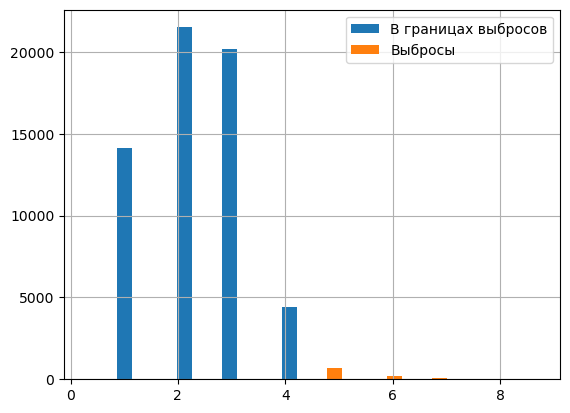

In [55]:
utils.analyse_numeric(df, 'live_rooms')

**Здесь, возможно, нужно удалить все записи со значением live_rooms > 4**

In [56]:
df.drop(df[df.live_rooms > 4].index, inplace=True)

In [57]:
len(df)

60255

### total_square

Количество: 60255, Среднее: 66.569, Стандартное отклонение: 33.075.
Минимум: 8.97, 25-й перцентиль: 44.0, Медиана: 60.0, 75-й перцентиль: 78.0, Максимум: 450.0, IQR: 34.0.
Количество пропусков в столбце:  0
Границы выбросов: [-7.0, 129.0]. Количество выбросов:  3409


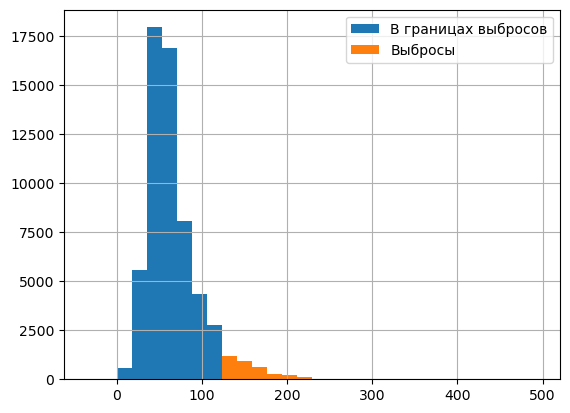

In [58]:
utils.analyse_numeric(df, 'total_square')

Квартиры с площадью > 180 м² будем считать аномалиями. **Это значение нужно подбирать** 

In [59]:
df.drop(df[df.total_square > 180].index, inplace=True)

### living_square и kitchen_square

In [60]:
df.loc[df.living_square >= df.total_square, 'living_square'] = 0

Количество: 59657, Среднее: 14.664, Стандартное отклонение: 22.314.
Минимум: 0.0, 25-й перцентиль: 0.0, Медиана: 0.0, 75-й перцентиль: 28.5, Максимум: 162.4, IQR: 28.5.
Количество пропусков в столбце:  0
Границы выбросов: [-42.75, 71.25]. Количество выбросов:  1430


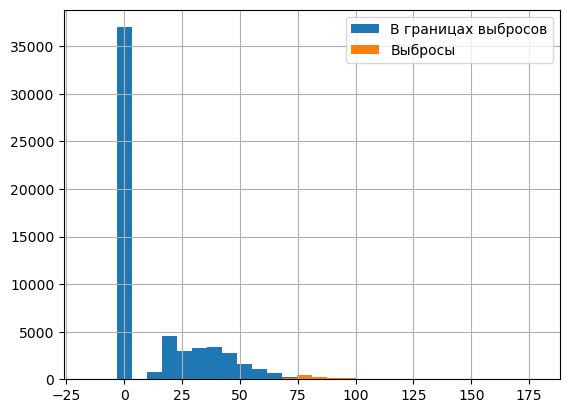

In [61]:
utils.analyse_numeric(df, 'living_square')

Признак **living_square** не так важен и содержит много пропусков. Лучше его удалить.

In [62]:
df.drop(['living_square'], axis=1, inplace=True)

In [63]:
df.loc[df.kitchen_square >= df.total_square, 'kitchen_square'] = 0

In [64]:
len(df[df.kitchen_square == 0])

19952

**Можно попробовать заменить пропуски медианой, либо оставить значение нулевым (0)**

In [65]:
#df.loc[df.kitchen_square == 0, 'kitchen_square'] = df.kitchen_square.median()

Количество: 59657, Среднее: 6.755, Стандартное отклонение: 6.042.
Минимум: 0.0, 25-й перцентиль: 0.0, Медиана: 6.0, 75-й перцентиль: 10.7, Максимум: 80.0, IQR: 10.7.
Количество пропусков в столбце:  0
Границы выбросов: [-16.049999999999997, 26.749999999999996]. Количество выбросов:  289


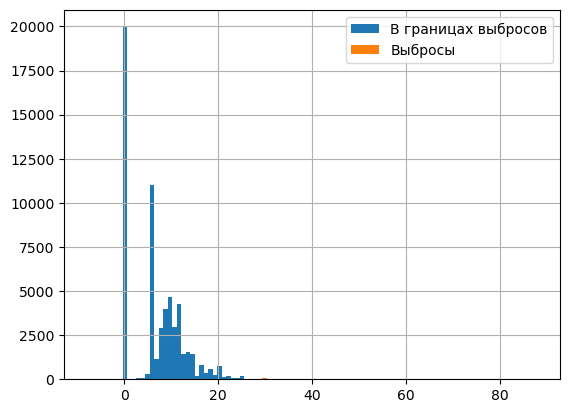

In [66]:
utils.analyse_numeric(df, 'kitchen_square', bns=100)

### flat_floor

In [67]:
df['flat_floor'].value_counts(dropna=False)

flat_floor
2     8980
4     8365
3     8295
1     7704
5     7521
6     2879
8     2811
9     2787
7     2769
10    1618
12    1155
11    1041
0      770
13     574
14     557
16     518
15     503
17     245
18     180
19     137
20      90
21      80
25      23
22      22
23      11
24      10
26       6
27       2
99       1
58       1
77       1
70       1
Name: count, dtype: int64

In [68]:
df[df['flat_floor'] > 25]

,district,live_rooms,price,address,text_preview,owner,ad_date,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,flat.building,flat.renovation,flat.toilet,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,live.furniture,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,flat.priv_dorm,options_text,text,total_square,kitchen_square,flat_floor,building_floor
7835,2,3,28499900,"Ауэзовский р-н, мкр Жетысу-1, Мкр Жетысу-1","панельный дом, 1989 г.п., состояние: хорошее, жил. площадь 55 кв.м., кухня 15 кв.м., санузел раздельный, телефон: отдельный, интернет ADSL, частично меблирована, ВНИМАНИЕ! 3-х комнатная квартира в...",4,13 мар.,0,0,0,0,0,0,"панельный, 1989 г.п.",хорошее,раздельный,балкон и лоджия,да,NaN,металлическая,ADSL,частично меблирована,NaN,NaN,домофон,NaN,отдельный,рядом охраняемая стоянка,нет,"Пластиковые окна, неугловая, улучшенная, комнаты изолированы, новая сантехника, счётчики, тихий двор.","ВНИМАНИЕ! 3-х комнатная квартира в одном из самых востребованных районов города. Соотношение ЦЕНА-СОСТОЯНИЕ-расположенИЕ! \nРазвитая инфраструктура, квартира и район со всеми удобствами для жизни,...",70.0,15.0,99,0
9527,3,2,64000000,"Бостандыкский р-н, Аль-Фараби 7 — Козыбаева","жил. комплекс Нурлы Тау, монолитный дом, 2005 г.п., Очень хорошая квартира, 2 су, встроенный шкаф - купе, удобный кухонный гарнитур, паркинг. квартира продается полностью с мебелью и техникой",3,21 мар.,0,0,0,0,0,0,"монолитный, 2005 г.п.",NaN,NaN,NaN,NaN,Нурлы Тау,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,"Очень хорошая квартира, 2 су, встроенный шкаф - купе, удобный кухонный гарнитур, паркинг. квартира продается полностью с мебелью и техникой",95.0,0.0,27,29
15099,3,3,28000000,"Бостандыкский р-н, Навои","панельный дом, 1973 г.п., Теплая, светлая квартира в хорошем состоянии с адекватной ценой. Документы в порядке. Светлая, уютная. Частично мебель остается. Хороший двор, приветливые, улбычивые сосе...",4,6 мар.,0,0,0,0,0,0,"панельный, 1973 г.п.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,"Теплая, светлая квартира в хорошем состоянии с адекватной ценой. \nДокументы в порядке. \nСветлая, уютная. \nЧастично мебель остается. \nХороший двор, приветливые, улбычивые соседи. \nИфраструктур...",58.0,0.0,58,0
27216,1,3,35000000,"Алмалинский р-н, проспект Райымбека 243","монолитный дом, 2007 г.п., состояние: евроремонт, потолки 2.8м., санузел раздельный, телефон: отдельный, интернет ADSL, частично меблирована",6,25 мар.,0,0,0,0,0,0,"монолитный, 2007 г.п.",евроремонт,раздельный,лоджия,да,NaN,металлическая,ADSL,частично меблирована,линолеум,2.8 м,"домофон, видеонаблюдение",NaN,отдельный,NaN,нет,"Пластиковые окна, неугловая, улучшенная, комнаты изолированы, встроенная кухня, новая сантехника, счётчики, тихий двор, кондиционер.",NaN,75.0,14.0,77,9
29901,3,2,60000000,"Бостандыкский р-н, Аль-Фараби 7","жил. комплекс Нурлы Тау, монолитный дом, 2005 г.п., состояние: хорошее, потолки 2.85м., санузел 2 с/у и более, телефон: отдельный, интернет ADSL, частично меблирована, Вашему вниманию представляет...",4,19 мар.,1,0,0,0,0,0,"монолитный, 2005 г.п.",хорошее,2 с/у и более,NaN,NaN,Нурлы Тау,металлическая,ADSL,частично меблирована,ламинат,2.85 м,"охрана, домофон, видеонаблюдение, консьерж",NaN,отдельный,паркинг,нет,"Пластиковые окна, кухня-студия, новая сантехника, счётчики, тихий двор, кондиционер, удобно под коммерцию.","Вашему вниманию представляется 2-х комнатная квартира - просторные комнаты с удобной планировкой. \nТеплая, светлая и очень уютная, обставленная мебелью и техникой. \nОчень развитая инфраструктура...",94.0,0.0,26,32
31321,3,2,54000000,"Бостандыкский р-н, Ходжанова","монолитный дом, 2007 г.п., состояние: хорошее, санузел раздельный, телефон: есть возможность подключения, интернет ADSL, Пластиковые окна, комнаты изолированы, встроенная кухня, тихий двор. Кварти...",4,15 мар.,0,0,0,0,0,0,"монолитный, 2007 г.п.",хорошее,раздельный,балкон,NaN,NaN,металлическая,ADSL,NaN,NaN,NaN,домофон,NaN,есть возможнос

Визуальный просмотр показывает, что объявления по квартирам со значением этажа > 25 содержат ошибки, дубли и их мало. Удалим записи со значением > 20.

In [69]:
df.drop(df[df.flat_floor > 20].index, inplace=True)

Количество: 59499, Среднее: 4.878, Стандартное отклонение: 3.644.
Минимум: 0, 25-й перцентиль: 2.0, Медиана: 4.0, 75-й перцентиль: 7.0, Максимум: 20, IQR: 5.0.
Количество пропусков в столбце:  0
Границы выбросов: [-5.5, 14.5]. Количество выбросов:  1673


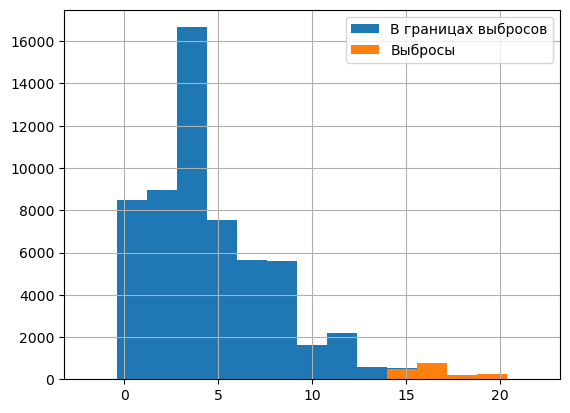

In [70]:
utils.analyse_numeric(df, 'flat_floor', bns=15)

**Можно попробовать заменить пропуски медианой, либо оставить значение нулевым (0)**

In [71]:
df.loc[df.flat_floor == 0, 'flat_floor'] = df.flat_floor.median()

### building_floor

In [72]:
df['building_floor'].value_counts(dropna=False)

building_floor
5      16138
9       8609
4       8293
12      4625
10      3283
16      2709
13      1828
3       1794
0       1633
6       1546
2       1146
14      1074
15       921
18       907
17       891
7        853
8        845
21       682
11       403
20       400
25       281
22       246
19       178
1        111
23        30
33        29
30        24
32         4
29         4
31         2
24         2
54         1
76         1
100        1
49         1
98         1
121        1
252        1
28         1
Name: count, dtype: int64

In [73]:
df[df['building_floor'] > 33]

,district,live_rooms,price,address,text_preview,owner,ad_date,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,flat.building,flat.renovation,flat.toilet,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,live.furniture,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,flat.priv_dorm,options_text,text,total_square,kitchen_square,flat_floor,building_floor
7188,3,4,42500000,"Бостандыкский р-н, Розыбакиева 153А","кирпичный дом, 1974 г.п., состояние: хорошее, санузел раздельный, телефон: отдельный, интернет ADSL, полностью меблирована, Балкон довольно просторный Дом после капитального ремонта Квартира очень...",4,22 мар.,0,0,0,0,0,0,"кирпичный, 1974 г.п.",хорошее,раздельный,балкон и лоджия,NaN,NaN,металлическая,ADSL,полностью меблирована,линолеум,NaN,домофон,NaN,отдельный,NaN,нет,"Пластиковые окна, неугловая, улучшенная, комнаты изолированы, кухня-студия, встроенная кухня, новая сантехника, кладовка, счётчики, тихий двор.","Балкон довольно просторный Дом после капитального ремонта Квартира очень просторная, светлая. Индивидуальная планировка квартиры полностью узаконена. Имеются все соответствующие документы. Дом пов...",85.0,0.0,4,54
15037,3,3,75000000,"Бостандыкский р-н, проспект Гагарина","монолитный дом, 2018 г.п., состояние: евроремонт, санузел 2 с/у и более, интернет проводной, полностью меблирована",4,6 мар.,0,0,0,0,0,0,"монолитный, 2018 г.п.",евроремонт,2 с/у и более,NaN,NaN,NaN,металлическая,проводной,полностью меблирована,ламинат,NaN,"охрана, домофон, видеонаблюдение",NaN,NaN,NaN,нет,"Пластиковые окна, неугловая, улучшенная, комнаты изолированы, кухня-студия, встроенная кухня, новая сантехника, счётчики.",NaN,108.0,0.0,7,76
15761,3,3,50100000,"Бостандыкский р-н, Навои","жил. комплекс Тау Самал на Навои, монолитный дом, 2011 г.п., состояние: хорошее, жил. площадь 55 кв.м., кухня 19 кв.м., потолки 3м., санузел раздельный, частично меблирована, От специалиста компан...",4,2 мар.,0,0,0,0,0,0,"монолитный, 2011 г.п.",хорошее,раздельный,NaN,NaN,Тау Самал на Навои,NaN,NaN,частично меблирована,NaN,3 м,домофон,NaN,NaN,паркинг,нет,"Пластиковые окна, неугловая, улучшенная, встроенная кухня, новая сантехника, счётчики.","От специалиста компании ""ATRIUM"" продается квартира в уютном доме. Дом каркасно-монолитный, 2011 года, состояние отличное. Квартира не залоговая, улучшенная, комнаты изолированные, большой благоус...",103.0,19.0,3,100
18263,1,2,25500000,"Алмалинский р-н, Макатаева (Пастера) — Абылай хана (Коммунистический)","кирпичный дом, 1979 г.п., состояние: среднее, жил. площадь 30 кв.м., кухня 9 кв.м., санузел раздельный, пустая, (№61387) 2 КОМТНАТНАЯ улУЧШЕННОЙ ПЛАНИРОВКИ, НЕУГЛОВАЯ КВАРТИРА. Удобная транспортна...",4,20 мар.,0,0,0,0,0,0,"кирпичный, 1979 г.п.",среднее,раздельный,NaN,NaN,NaN,NaN,NaN,пустая,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,"(№61387) 2 КОМТНАТНАЯ улУЧШЕННОЙ ПЛАНИРОВКИ, НЕУГЛОВАЯ КВАРТИРА. Удобная транспортная развязка. Развитая инфраструктура - магазины, школы, банки, аптеки, детские сады, поликлиники. Квартиру можно ...",49.4,9.0,5,49
31237,3,2,35800000,"Бостандыкский р-н, Жамбыла","жил. комплекс Алма-Ата, монолитный дом, 2015 г.п., состояние: хорошее, потолки 3м., санузел совмещенный, телефон: отдельный, интернет ADSL, полностью меблирована, Отличная квартира по хорошей цене...",4,15 мар.,0,0,0,0,0,0,"монолитный, 2015 г.п.",хорошее,совмещенный,NaN,NaN,Алма-Ата,бронированная,ADSL,полностью меблирована,NaN,3 м,домофон,NaN,отдельный,паркинг,нет,"Пластиковые окна, кухня-студия, встроенная кухня, новая сантехника, тихий двор.","Отличная квартира по хорошей цене в ЖК Алма-Ата! Развитая инфраструктура, рядом школы, детсады, остановки, станция метро, ТРЦ Глобус, и т.д. \nОтличный вариант на сдачу или для семейной пары. \nПо...",62.0,0.0,5,98
32815,2,2,25000000,"Ауэзовский р-н, мкр Аксай-1 25","монолитный дом, 1994 г.п., состояние: хорошее, потолки 2.8м., санузел раздельный, телефон: отдельный, интернет ADSL, частично меблирована, Срочно! Продам отличную 2-х комнатную квартиру, 

Удалим записи со значением > 33

In [74]:
df.drop(df[df.building_floor > 33].index, inplace=True)

**Можно попробовать заменить пропуски медианой, либо оставить значение нулевым (0)**

In [75]:
df.loc[df.building_floor == 0, 'building_floor'] = df.building_floor.median()

Количество: 59492, Среднее: 8.270, Стандартное отклонение: 4.693.
Минимум: 1, 25-й перцентиль: 5.0, Медиана: 6.0, 75-й перцентиль: 11.0, Максимум: 33, IQR: 6.0.
Количество пропусков в столбце:  0
Границы выбросов: [-4.0, 20.0]. Количество выбросов:  1305


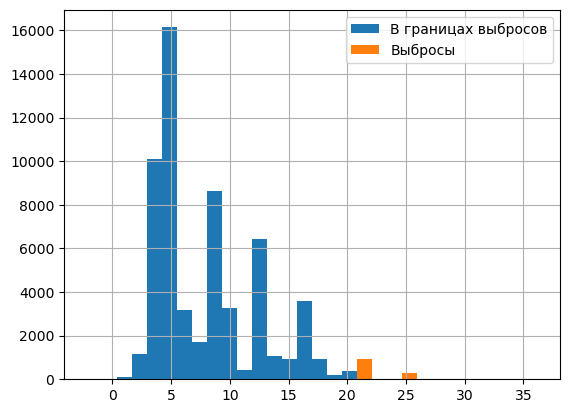

In [76]:
utils.analyse_numeric(df, 'building_floor')

In [77]:
df.sample(1)

,district,live_rooms,price,address,text_preview,owner,ad_date,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,flat.building,flat.renovation,flat.toilet,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,live.furniture,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,flat.priv_dorm,options_text,text,total_square,kitchen_square,flat_floor,building_floor
59336,3,3,59000000,"Бостандыкский р-н, Навои","монолитный дом, 2014 г.п., состояние: евроремонт, санузел раздельный, полностью меблирована, Код объекта #5601469 Уважаемые гости и жители г. Алматы! Международное агентство недвижимости ""Этажи"" п...",4,26 мар.,0,0,0,0,0,0,"монолитный, 2014 г.п.",евроремонт,раздельный,NaN,NaN,NaN,металлическая,NaN,полностью меблирована,ламинат,NaN,"охрана, домофон, видеонаблюдение, консьерж",NaN,NaN,рядом охраняемая стоянка,нет,"Пластиковые окна, кухня-студия, встроенная кухня.","Код объекта #5601469 \nУважаемые гости и жители г. Алматы! \nМеждународное агентство недвижимости ""Этажи"" представляет Вашему вниманию трехкомнатную квартиру в ЖК ""Шахристан"". \nВ квартире сделан ...",101.3,0.0,12,18


### price - целевая переменная

Количество: 59492, Среднее: 32996811.066, Стандартное отклонение: 21842496.452.
Минимум: 2500000, 25-й перцентиль: 20000000.0, Медиана: 26500000.0, 75-й перцентиль: 38500000.0, Максимум: 555000000, IQR: 18500000.0.
Количество пропусков в столбце:  0
Границы выбросов: [-7750000.0, 66250000.0]. Количество выбросов:  4143


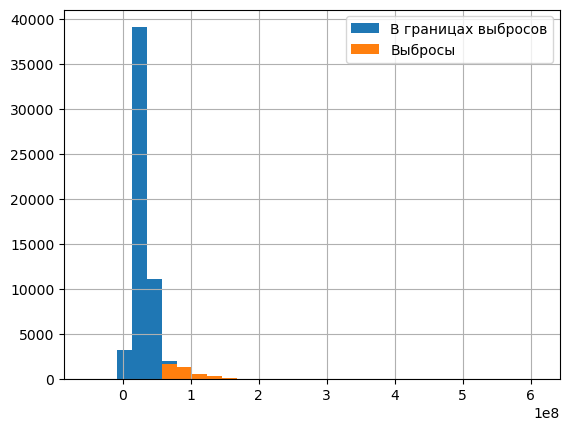

In [78]:
utils.analyse_numeric(df, 'price')

Квартиры ценой > 200000000 (200 млн. тенге) будем считать аномалиями. Это значение нужно подбирать

In [79]:
df.drop(df[df.price > 200000000].index, inplace=True)

Количество: 59456, Среднее: 32860125.841, Стандартное отклонение: 21046296.375.
Минимум: 2500000, 25-й перцентиль: 20000000.0, Медиана: 26500000.0, 75-й перцентиль: 38500000.0, Максимум: 200000000, IQR: 18500000.0.
Количество пропусков в столбце:  0
Границы выбросов: [-7750000.0, 66250000.0]. Количество выбросов:  4107


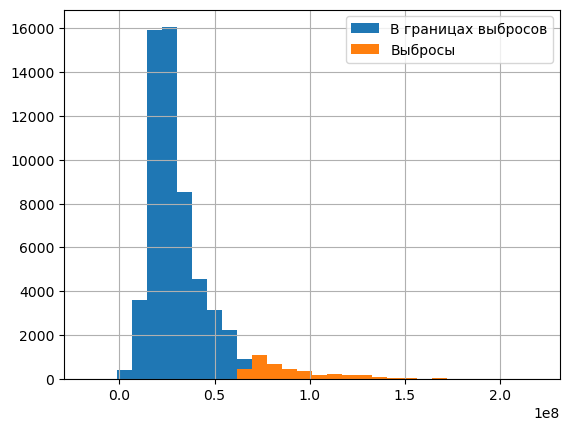

In [80]:
utils.analyse_numeric(df, 'price')

Порядок значений цены можно понизить, поделив все на 1000000.0

In [81]:
df.price = df.price / 1000000.0

Количество: 59456, Среднее: 32.860, Стандартное отклонение: 21.046.
Минимум: 2.5, 25-й перцентиль: 20.0, Медиана: 26.5, 75-й перцентиль: 38.5, Максимум: 200.0, IQR: 18.5.
Количество пропусков в столбце:  0
Границы выбросов: [-7.75, 66.25]. Количество выбросов:  4107


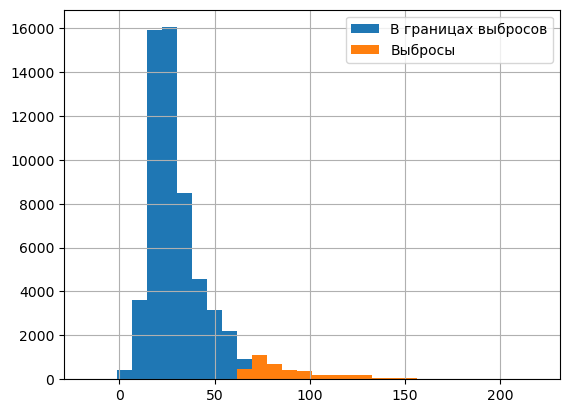

In [82]:
#plt.rcParams['figure.figsize'] = (10,7)
utils.analyse_numeric(df, 'price')

### ad_date - дата подачи объявления.
Возможно, нам пригодится признак days - количество дней между максимальной датой и датой подачи объявления, если, к примеру, квартиры со временем дорожают.

In [83]:
df.ad_date.value_counts()[:5]

ad_date
26 мар.    3697
25 мар.    3489
27 мар.    3131
24 мар.    2976
1 мар.     2781
Name: count, dtype: int64

In [84]:
loca = locale.getlocale()
loca

('en_US', 'UTF-8')

In [85]:
locale.setlocale(locale.LC_ALL, 'ru_RU.utf8')  # ru_RU

'ru_RU.utf8'

In [86]:
df.ad_date = df.ad_date.apply(lambda x: x.replace('.', ' 2021'))

In [87]:
df.ad_date = df.ad_date.apply(lambda x: x.replace('февр', 'фев'))

In [88]:
df.ad_date.value_counts()[::6]

ad_date
26 мар 2021    3697
9 мар 2021     2591
18 мар 2021    2166
16 мар 2021    2046
21 мар 2021    1091
Name: count, dtype: int64

In [89]:
df.ad_date = pd.to_datetime(df.ad_date, format = '%d %b %Y')

In [90]:
locale.setlocale(locale.LC_ALL, loca)

'en_US.UTF-8'

In [91]:
min(df.ad_date), max(df.ad_date)

(Timestamp('2021-02-28 00:00:00'), Timestamp('2021-03-29 00:00:00'))

In [92]:
max_date = max(df.ad_date)
df['days'] = df.ad_date.apply(lambda x: (max_date - x).days + 1)

<Axes: >

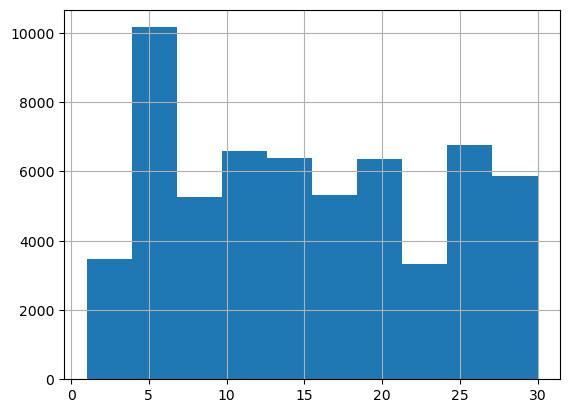

In [93]:
df.days.hist()

In [94]:
df.drop(['ad_date'], axis=1, inplace=True)

In [95]:
len(df)

59456

### flat.building

In [96]:
df['flat.building'].value_counts(dropna=False)

flat.building
монолитный, 2016 г.п.    3904
монолитный, 2017 г.п.    3006
монолитный, 2018 г.п.    2212
монолитный, 2015 г.п.    2024
монолитный, 2020 г.п.    1641
                         ... 
кирпичный, 1935 г.п.        1
4, 1962 г.п.                1
иное, 1992 г.п.             1
1940 г.п.                   1
панельный, 1957 г.п.        1
Name: count, Length: 374, dtype: int64

In [97]:
df['flat.building'].isna().sum()

0

Извлечем Год постройки

In [98]:
def extract_building_year(str_year):
    arr_tmp = str_year.split(', ', 1)
    if len(arr_tmp) == 1:
        return int(arr_tmp[0].split(' г.п.', 1)[0])
    elif len(arr_tmp) == 2:
        return int(arr_tmp[1].split(' г.п.', 1)[0])
    else:
        print(str_year)
        return np.nan

In [99]:
def extract_building_type(str_year):
    arr_tmp = str_year.split(', ', 1)
    if len(arr_tmp) == 1:
        return 'unknown'
    elif len(arr_tmp) == 2:
        return arr_tmp[0]
    else:
        print(str_year)
        return None

In [100]:
PRESENT_YEAR = 2021

In [101]:
df['building_age'] = df['flat.building'].apply(lambda x: extract_building_year(x))

In [102]:
df[df.building_age < 1930]

,district,live_rooms,price,address,text_preview,owner,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,flat.building,flat.renovation,flat.toilet,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,live.furniture,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,flat.priv_dorm,options_text,text,total_square,kitchen_square,flat_floor,building_floor,days,building_age
4624,0,1,13.500,"Алатауский р-н, мкр Саялы 20","монолитный дом, 1915 г.п., состояние: хорошее, потолки 2.8м., санузел совмещенный, пустая, ВНИМАНИЕ ЭКСКЛЮЗИВ 🔥 Предлагаем вам выгодно приобрести 1 комнатную улучшенную квартиру, в стремительно ра...",4,0,0,0,0,0,0,"монолитный, 1915 г.п.",хорошее,совмещенный,лоджия,NaN,NaN,металлическая,NaN,пустая,линолеум,2.8 м,NaN,NaN,NaN,рядом охраняемая стоянка,нет,"Пластиковые окна, неугловая, счётчики, тихий двор.","ВНИМАНИЕ ЭКСКЛЮЗИВ 🔥 \n \nПредлагаем вам выгодно приобрести 1 комнатную улучшенную квартиру, в стремительно развивающемся районе. \nВсе удобства для жизни. Большая, просторная парковка, множество ...",40.0,10.0,5,6,27,1915
11844,2,2,20.500,"Ауэзовский р-н, мкр №6, Мкр №6 3А","панельный дом, 1919 г.п., состояние: хорошее, санузел совмещенный, Пластиковые окна, неугловая, комнаты изолированы. Дом расположен прямо по Абая, но окна выходят во двор. Пластиковые окна, решетк...",4,0,0,0,0,0,0,"панельный, 1919 г.п.",хорошее,совмещенный,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,"Пластиковые окна, неугловая, комнаты изолированы. \nДом расположен прямо по Абая, но окна выходят во двор. Пластиковые окна, решетки. Балкон застеклен. Очень теплая. Район удобный с развитой инфра...",42.0,6.0,2,5,3,1919
40212,2,3,37.999,"Ауэзовский р-н, Саина 10/3","жил. комплекс Самга, монолитный дом, 1917 г.п., состояние: хорошее, потолки 2.7м., санузел раздельный, телефон: отдельный, частично меблирована, Срочная продажа, развитая инфраструктура, транспорт...",0,0,0,0,1,0,0,"монолитный, 1917 г.п.",хорошее,раздельный,балкон и лоджия,да,Самга,NaN,NaN,частично меблирована,ламинат,2.7 м,домофон,NaN,отдельный,рядом охраняемая стоянка,нет,"Пластиковые окна, неугловая, улучшенная, комнаты изолированы, встроенная кухня, новая сантехника, счётчики, тихий двор.","Срочная продажа, развитая инфраструктура, транспорт в любую часть города",90.0,15.0,6,12,28,1917
45856,0,1,13.300,"Алатауский р-н, мкр Саялы, Мкр Саялы","монолитный дом, 1915 г.п., состояние: хорошее, потолки 2.8м., санузел совмещенный, пустая, ВНИМАНИЕ ЭКСКЛЮЗИВ 🔥 Предлагаем вам выгодно приобрести 1 комнатную улучшенную квартиру, в стремительно ра...",4,1,0,0,0,0,0,"монолитный, 1915 г.п.",хорошее,совмещенный,лоджия,NaN,NaN,металлическая,NaN,пустая,линолеум,2.8 м,NaN,NaN,NaN,рядом охраняемая стоянка,нет,"Пластиковые окна, неугловая, счётчики, тихий двор.","ВНИМАНИЕ ЭКСКЛЮЗИВ 🔥 \n \nПредлагаем вам выгодно приобрести 1 комнатную улучшенную квартиру, в стремительно развивающемся районе. \nВсе удобства для жизни. Большая, просторная парковка, множество ...",40.0,10.0,4,5,21,1915
52851,3,3,80.000,"Бостандыкский р-н, мкр Баганашыл, Аль-Фараби 144","жил. комплекс Горное Солнце, монолитный дом, 1916 г.п., состояние: хорошее, жил. площадь 100 кв.м., кухня 20 кв.м., потолки 3м., санузел 2 с/у и более, телефон: отдельный, интернет оптика, частичн...",6,0,0,0,0,0,0,"монолитный, 1916 г.п.",хорошее,2 с/у и более,NaN,NaN,Горное Солнце,металлическая,оптика,частично меблирована,NaN,3 м,"охрана, домофон",NaN,отдельный,паркинг,нет,"Пластиковые окна, улучшенная, комнаты изолированы, кухня-студия, встроенная кухня, новая сантехника, счётчики, тихий двор.","Рядом спортивный комплекс, сад, парк.",105.0,20.0,2,4,19,1916
53987,2,3,28.400,"Ауэзовский р-н, проспект Райымбека 508 — Саина","панельный дом, 1876 г.п., состояние: хорошее, санузел раздельный, Квартира находится в очень хорошем и развитом районе города. Сантехника в отличном состоянии. Квартира полностью готова к продаже....",4,0,0,0,0,0,0,"панельный, 1876 г.п.",хорошее,раздельный,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

Исправим ошибки в годе постройки и преобразуем к возрасту постройки + 1

In [103]:
df.building_age = df.building_age.apply(lambda x: x + 100 if x < 1930 else x)
df.building_age = (PRESENT_YEAR + 1) - df.building_age

In [104]:
df.building_age.value_counts()

building_age
6     4191
5     3262
4     2447
7     2215
2     1958
      ... 
92       2
87       1
85       1
86       1
91       1
Name: count, Length: 92, dtype: int64

Теперь извлечем Тип постройки (материал)

In [105]:
df['building_type'] = df['flat.building'].apply(lambda x: extract_building_type(x))

In [106]:
df.building_type.value_counts(dropna=False)

building_type
монолитный    26315
панельный     18058
кирпичный     11582
unknown        2793
иное            705
4                 3
Name: count, dtype: int64

In [107]:
df['building_type'] = df['building_type'].astype('category').cat.codes

In [108]:
df.building_type.value_counts(dropna=False)

building_type
4    26315
5    18058
3    11582
1     2793
2      705
0        3
Name: count, dtype: int64

In [109]:
df.drop(['flat.building'], axis=1, inplace=True)

### flat.priv_dorm

In [110]:
df['flat.priv_dorm'].value_counts(dropna=False)

flat.priv_dorm
нет    52505
NaN     5455
да      1496
Name: count, dtype: int64

In [111]:
df['flat_priv_dorm'] = df['flat.priv_dorm']

In [112]:
df.loc[df['flat_priv_dorm'].isna(), 'flat_priv_dorm'] = 'нет'

In [113]:
df['flat_priv_dorm'] = df['flat_priv_dorm'].astype('category').cat.codes

In [114]:
df['flat_priv_dorm'].value_counts(dropna=False)

flat_priv_dorm
1    57960
0     1496
Name: count, dtype: int64

In [115]:
df.drop(['flat.priv_dorm'], axis=1, inplace=True)

### flat.renovation

In [116]:
df['flat.renovation'].value_counts(dropna=False)

flat.renovation
хорошее                 23347
евроремонт              21418
среднее                  5000
NaN                      4607
требует ремонта          1971
черновая отделка         1888
свободная планировка     1225
Name: count, dtype: int64

In [117]:
df['flat_renovation'] = df['flat.renovation']

In [118]:
df.loc[df['flat_renovation'].isna(), 'flat_renovation'] = 'хорошее'

In [119]:
df['flat_renovation'] = df['flat_renovation'].astype('category').cat.codes

In [120]:
df['flat_renovation'].value_counts(dropna=False)

flat_renovation
4    27954
0    21418
2     5000
3     1971
5     1888
1     1225
Name: count, dtype: int64

In [121]:
df.drop(['flat.renovation'], axis=1, inplace=True)

### flat.toilet

In [122]:
df['flat.toilet'].value_counts(dropna=False)

flat.toilet
совмещенный      24928
раздельный       16717
NaN               9777
2 с/у и более     7967
нет                 67
Name: count, dtype: int64

In [123]:
df['flat_toilet'] = df['flat.toilet']

In [124]:
df.loc[df['flat_toilet'].isna(), 'flat_toilet'] = 'unknown'

In [125]:
df['flat_toilet'] = df['flat_toilet'].astype('category').cat.codes

In [126]:
df['flat_toilet'].value_counts(dropna=False)

flat_toilet
4    24928
3    16717
1     9777
0     7967
2       67
Name: count, dtype: int64

In [127]:
df.drop(['flat.toilet'], axis=1, inplace=True)

### live.furniture

In [128]:
df['live.furniture'].value_counts(dropna=False)

live.furniture
частично меблирована     21533
NaN                      16708
полностью меблирована    16328
пустая                    4887
Name: count, dtype: int64

In [129]:
df['live_furniture'] = df['live.furniture']

In [130]:
df.loc[df['live_furniture'].isna(), 'live_furniture'] = 'частично меблирована'

In [131]:
df['live_furniture'] = df['live_furniture'].astype('category').cat.codes

In [132]:
df['live_furniture'].value_counts(dropna=False)

live_furniture
2    38241
0    16328
1     4887
Name: count, dtype: int64

In [133]:
df.drop(['live.furniture'], axis=1, inplace=True)

## 3. Генерация новых признаков (feature engineering)
Первый этаж, Последний этаж, Отношение площади к количеству комнат.

In [134]:
df.flat_floor.value_counts()

flat_floor
4     9126
2     8976
3     8287
1     7702
5     7517
6     2877
8     2811
9     2787
7     2765
10    1618
12    1153
11    1041
13     574
14     550
16     518
15     503
17     244
18     180
19     137
20      90
Name: count, dtype: int64

In [135]:
df['first_floor'] = df.flat_floor.apply(lambda x: 1 if x==1 else 0)

In [136]:
df[df.flat_floor > df.building_floor]

,district,live_rooms,price,address,text_preview,owner,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,options_text,text,total_square,kitchen_square,flat_floor,building_floor,days,building_age,building_type,flat_priv_dorm,flat_renovation,flat_toilet,live_furniture,first_floor
218,1,1,24.50000,"Алмалинский р-н, Егизбаева","жил. комплекс Асыл Тау, монолитный дом, 2016 г.п., состояние: евроремонт, потолки 2.7м., интернет оптика, частично меблирована",4,0,0,0,0,0,0,лоджия,да,Асыл Тау,бронированная,оптика,ламинат,2.7 м,"охрана, домофон, видеонаблюдение",NaN,NaN,рядом охраняемая стоянка,"Пластиковые окна, неугловая, встроенная кухня, новая сантехника, счётчики, тихий двор, кондиционер.",NaN,44.0,10.0,17,6,27,6,4,1,0,1,2,0
296,1,1,20.00000,"Алмалинский р-н, Толе би","жил. комплекс Эдельвейс, монолитный дом, 2016 г.п., состояние: евроремонт, потолки 2.7м",4,0,0,0,0,0,0,NaN,NaN,Эдельвейс,NaN,NaN,NaN,2.7 м,"охрана, домофон, видеонаблюдение",NaN,NaN,NaN,"Пластиковые окна, неугловая, встроенная кухня, счётчики, тихий двор, кондиционер.",NaN,44.0,12.0,12,6,28,6,4,1,0,1,2,0
388,5,3,34.50000,"Наурызбайский р-н, мкр Шугыла, Жунисова 14/3","жил. комплекс Alma City, монолитный дом, 2020 г.п., состояние: евроремонт, потолки 2.8м., санузел 2 с/у и более, телефон: есть возможность подключения, пустая, Светлая, уютная квартиру с новым рем...",6,1,0,1,0,0,0,балкон,нет,Alma City,металлическая,NaN,ламинат,2.8 м,"домофон, кодовый замок, видеонаблюдение",NaN,есть возможность подключения,NaN,"Пластиковые окна, неугловая, улучшенная, комнаты изолированы, кухня-студия, счётчики.","Светлая, уютная квартиру с новым ремонтом по дизайн проекту для комфортного проживания семьи. \nДелали все качественно для себя, идеально выровнены стены и пол, полностью проведена электрика и рас...",91.7,0.0,10,6,17,2,4,1,0,0,1,0
429,5,3,34.99900,"Наурызбайский р-н, Жуалы","жил. комплекс Премьера, монолитный дом, 2014 г.п., состояние: евроремонт, потолки 2.8м., телефон: отдельный, интернет оптика, частично меблирована",4,0,0,0,0,0,0,балкон,да,Премьера,металлическая,оптика,ламинат,2.8 м,"охрана, домофон, видеонаблюдение",NaN,отдельный,паркинг,"Пластиковые окна, улучшенная, встроенная кухня, новая сантехника, счётчики, тихий двор, кондиционер.",NaN,110.0,0.0,16,6,21,8,4,1,0,1,2,0
622,1,2,28.86092,"Алмалинский р-н, Толе би 189/3","жил. комплекс Nomad, монолитный дом, 2021 г.п., потолки 2.7м., Стильный и современный, комфортный и доступный— это все о новом жилом комплексе Nomad от строительной компании Rams Qazaqstan. Его бу...",4,0,0,0,0,0,0,NaN,NaN,Nomad,NaN,NaN,NaN,2.7 м,NaN,NaN,NaN,NaN,"Пластиковые окна, улучшенная.","Стильный и современный, комфортный и доступный— это все о новом жилом комплексе Nomad от строительной компании Rams Qazaqstan. Его будущих жильцов ожидает близость всех важных объектов инфраструкт...",73.7,0.0,12,6,24,1,4,1,4,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60797,3,3,42.50000,"Бостандыкский р-н, Егизбаева","жил. комплекс Асыл Тау, монолитный дом, 2016 г.п., состояние: евроремонт, полностью меблирована, Продается квартира в востребованном районе. Развитая инфраструктура, всё в шаговой доступности! Пол...",4,0,0,0,0,0,0,балкон,NaN,Асыл Тау,металлическая,NaN,ламинат,NaN,"охрана, домофон",NaN,NaN,NaN,"Пластиковые окна, неугловая, улучшенная, комнаты изолированы, встроенная кухня, новая сантехника, кладовка, тихий двор, кондиционер.","Продается квартира в востребованном районе. Развитая инфраструктура, всё в шаговой доступности! Полное сопровождение сделки",87.0,0.0,17,6,7,6,4,1,0,1,0,0
60801,3,3,44.00000,"Бостандыкский р-н, Навои — Торайгырова","жил. комплекс Шахристан, монолитный дом, 2015 г.п., состояние: евроремонт, потолки 2.95м., санузел 2 с/у и более, полностью меблирована",4,0,0,0,0,0,0,NaN,NaN,Ш

In [137]:
df['last_floor'] = df.flat_floor - df.building_floor
df['last_floor'] = df['last_floor'].apply(lambda x: 1 if x == 0 else 0)

In [138]:
df['sqare_per_room'] = df.total_square / df.live_rooms

In [139]:
df.reset_index(drop=True, inplace=True)

### address

#### При обработке этого поля применим NLP

In [140]:
df.address.apply(lambda x: x.split(', ', 1)[0]).value_counts(dropna=False)

address
Бостандыкский р-н    18290
Ауэзовский р-н       11622
Алмалинский р-н      11379
Медеуский р-н         6238
Алатауский р-н        3578
Наурызбайский р-н     3068
Жетысуский р-н        2881
Турксибский р-н       2400
Name: count, dtype: int64

Можно удалить левую часть поля address (ту, что до знака ',')

In [141]:
def extract_address(str_address):
    tmp_arr = str_address.split(', ', 1)
    if len(tmp_arr) >= 2:
        return tmp_arr[1]
    else:
        return 'empty'

In [142]:
df.address = df.address.apply(lambda x: extract_address(x))

In [143]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import re

In [144]:
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# print(stopwords.words('russian'))

# result = re.search(r'мкр№\d+', 'fvvмкр№500ttvv 445')
# print(result.group(0))

# result = re.search(r'[а-я]+-\d+', 'айнабулак-3')
# if result is not None:
#     print(result.group(0))
# else:
#     print('None')

In [145]:
def stop_words_remover(text):
    '''Предобработка текстов: удаление дополнительных стоп-слов'''
    
    text = text.lower()
    
    text = text.replace('мкр №', 'мкр')
    text = text.replace('горный гигант', 'горныйгигант')
    text = text.replace('военный городок', 'военный городок')
    text = text.replace('яссауй', 'яссауи')
    text = text.replace('момушылы', 'момышулы')
    text = text.replace('момыш', 'момышулы')
    text = text.replace('момышұлы', 'момышулы')
    text = text.replace('момышулыұлы', 'момышулы')
    text = text.replace('момышулыулы', 'момышулы')    
    text = text.replace('толе би', 'толеби')
    text = text.replace('казбек би', 'казбекби')
    
    text = re.sub(r'\b\d+\b', '', text) # Удаляем цифры
    text = re.sub( r'\b\w\b', ' ', text ) # удаление отдельно стоящих букв
    text = re.sub( r'\b\d+\w+\b', ' ', text ) # удаление слов, начинающихся с цифры
   
    singles = [word for word in text.split()]
    text = ' '.join(singles)
        
    #Удаление незначимых слов
    stw = ['ул', 'улица', 'проспект', 'мкр', 'мкрн', 'бостандыкский', 'ауэзовский', 'алмалинский', 'медеуский', 'алатауский', 'наурызбайский',
           'жетысуский', 'турксибский', 'ая']
#     stw.extend(['restaura', 'restauran', 'restaurant', 'restaurante', 'restaurants', 'resto', 'restuarant',
#                 'restau', 'restaur', 'resturant'])
    
    remove = r'\b(' + '|'.join(stw) + r')\b'  
    text = re.sub(remove, ' ', text)
    
    return  text

In [146]:
vectorizer = CountVectorizer(ngram_range=(1, 1),
                             min_df=10,
                             max_df=0.7,
                             #decode_error='ignore'
                             #strip_accents='ascii', #'unicode', 'ascii', None
                             binary=True,
                            )                            
print(vectorizer)

CountVectorizer(binary=True, max_df=0.7, min_df=10)


In [147]:
df['address1'] = df.address.apply(lambda s: stop_words_remover(s))

In [148]:
Vect = vectorizer.fit_transform(df.address1)

In [149]:
num_samples_Vect, num_features_Vect = Vect.shape
print("#samples: %d, #features: %d" % (num_samples_Vect,  num_features_Vect))
print(len(vectorizer.get_feature_names_out()))
print(vectorizer.get_feature_names_out()[:20])

#samples: 59456, #features: 571
571
['абай' 'абая' 'абдуллиных' 'абиша' 'абишева' 'абылай' 'ади' 'айбасова'
 'айгерим' 'айманова' 'айнабуклак' 'айнабулак' 'айриха' 'айтеке' 'айтиева'
 'ак' 'акан' 'акбулак' 'акжар' 'аккент']


In [150]:
ind_test = 2

In [151]:
print(Vect[ind_test])
print(Vect.toarray().shape)

  (0, 182)	1
  (0, 558)	1
(59456, 571)


In [152]:
vectorizer.get_feature_names_out()[413], vectorizer.get_feature_names_out()[162]

('райымбек', 'емцова')

In [153]:
df[df.index==2].address

2    улица Желтоксан 156 — Шевченко
Name: address, dtype: object

Добавляем в dataframe столбцы с адресными признаками

In [154]:
features_matrix = Vect.toarray()
address_f = []
for i in range(features_matrix.shape[1]):
    feat_to_add = str(i) + '_f'
    address_f.append(feat_to_add)
    df[feat_to_add] = features_matrix[:,i]

/tmp/ipykernel_9475/2853874962.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feat_to_add] = features_matrix[:,i]
/tmp/ipykernel_9475/2853874962.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feat_to_add] = features_matrix[:,i]
/tmp/ipykernel_9475/2853874962.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `n

/tmp/ipykernel_9475/2853874962.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feat_to_add] = features_matrix[:,i]
/tmp/ipykernel_9475/2853874962.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feat_to_add] = features_matrix[:,i]
/tmp/ipykernel_9475/2853874962.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `n

Проверяем

In [155]:
df[df.index==2][['address', 'address1', '413_f', '162_f']]

,address,address1,413_f,162_f
2,улица Желтоксан 156 — Шевченко,желтоксан — шевченко,0,0


Забегая вперед, скажем, что обработка поля address и включение сгенерированных признаков дало выигрыш в MAPE на целый 1%

### Теперь поработаем с другими текстовыми признаками: 'text_preview', 'options_text' и 'text'
#### Попробуем извлечь из них ключевые слова: Неугловая, Улучшенная, и т.д.

Объединяем признаки в один

In [156]:
df['texts'] = df.text_preview + ' ' + df.options_text + ' ' + df.text

/tmp/ipykernel_9475/3038822697.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['texts'] = df.text_preview + ' ' + df.options_text + ' ' + df.text


In [157]:
pd.set_option('display.max_colwidth', None)

In [158]:
df[~pd.isna(df.texts)].sample(50).texts

29007                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         жил. комплекс Шахристан, монолитный дом, 2015 г.п., состояние: евроремонт, потолки 2.85м., санузел совмещенный, Продаю 2-ух комнатную квартиру в ЖК Шахристан (застройщик Базис-А/ Global Building), самое удачное расположение дома в жилом комплексе, находится на средн

### Часто встречаются следующие характеристики:

- требует ремонта
- улучшенная, улутшенная, улутшеная
- комнаты изолированные, комнаты изолированы
- пластиковые окна
- экологически чистый район
- кондиционер,
- угловая, неугловая, не угловая
- общежитие, не общежитие
- не в залоге, в залоге

### Сгенерируем признаки и попробуем использовать.

In [159]:
df['needs_repair'] = df.texts.apply(lambda x: 1 if (('требует ремонта' in str(x).lower()) & \
                                                    ('не требует ремонта' not in str(x).lower())) else 0)
df['improved'] = df.texts.apply(lambda x: 1 if (('улучшенная' in str(x).lower()) | \
                                                ('улутшенная' in str(x).lower()) | \
                                                ('улутшеная' in str(x).lower())) else 0)
df['rooms_isolated'] = df.texts.apply(lambda x: 1 if (('комнаты изолированные' in str(x).lower()) | \
                                                      ('комнаты изолированы' in str(x).lower())) else 0)
df['plastic_windows'] = df.texts.apply(lambda x: 1 if 'пластиковые окна' in str(x).lower() else 0)
df['ecologically_clean'] = df.texts.apply(lambda x: 1 if 'экологически чистый район' in str(x).lower() else 0)
df['air_conditioning'] = df.texts.apply(lambda x: 1 if 'кондиционер,' in str(x).lower() else 0)
df['not_at_corner'] = df.texts.apply(lambda x: 1 if (('неугловая' in str(x).lower()) | \
                                                     ('не угловая' in str(x).lower())) else 0)
df['pledged'] = df.texts.apply(lambda x: 1 if (('в залоге' in str(x).lower()) & \
                                               ('не в залоге' not in str(x).lower())) else 0)
df['not_pledged'] = df.texts.apply(lambda x: 1 if 'не в залоге' in str(x).lower() else 0)
df['dormitory'] = df.texts.apply(lambda x: 1 if (('общежитие' in str(x).lower()) & \
                                                 ('не общежитие' not in str(x).lower())) else 0)
df['not_dormitory'] = df.texts.apply(lambda x: 1 if 'не общежитие' in str(x).lower() else 0)

/tmp/ipykernel_9475/862344192.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['needs_repair'] = df.texts.apply(lambda x: 1 if (('требует ремонта' in str(x).lower()) & \
/tmp/ipykernel_9475/862344192.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['improved'] = df.texts.apply(lambda x: 1 if (('улучшенная' in str(x).lower()) | \
/tmp/ipykernel_9475/862344192.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

In [160]:
df.not_dormitory.value_counts()

not_dormitory
0    59405
1       51
Name: count, dtype: int64

### Наконец, остаются еще признаки, в которых наблюдается множеств пропусков.
#### Попробуем использовать и их (исключая столбецы 'has_change', который состоит почти из одних пропусков и 'ceiling', который кроме пропусков содержит много ошибок и, как следствие, очень большой спектр значений).

In [161]:
candidates_to_drop = ['flat.balcony','flat.balcony_g','map.complex','flat.door','inet.type',
                      'flat.flooring', 'flat.security','flat.phone','flat.parking'] # map.complex, flat.security - ?

In [162]:
df[candidates_to_drop].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59456 entries, 0 to 59455
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   flat.balcony    36462 non-null  object
 1   flat.balcony_g  27203 non-null  object
 2   map.complex     19371 non-null  object
 3   flat.door       41600 non-null  object
 4   inet.type       28344 non-null  object
 5   flat.flooring   36865 non-null  object
 6   flat.security   39373 non-null  object
 7   flat.phone      28124 non-null  object
 8   flat.parking    31261 non-null  object
dtypes: object(9)
memory usage: 4.1+ MB


Посмотрим на значения в этих столбцах

In [163]:
for col in candidates_to_drop:
    print(col, df[col].nunique(), '\n', df[col].value_counts(dropna=False), '\n')

flat.balcony 4 
 flat.balcony
NaN                              22994
балкон                           21638
лоджия                            7834
несколько балконов или лоджий     3997
балкон и лоджия                   2993
Name: count, dtype: int64 

flat.balcony_g 2 
 flat.balcony_g
NaN    32253
да     26757
нет      446
Name: count, dtype: int64 

map.complex 361 
 map.complex
NaN              40085
Шахристан          778
Alma City          613
Акварель           491
Алмалы             401
                 ...  
Кулагер              1
Алтын Ауыл           1
КД Абай              1
По Тимирязева        1
Родник               1
Name: count, Length: 362, dtype: int64 

flat.door 3 
 flat.door
металлическая    33633
NaN              17856
бронированная     7239
деревянная         728
Name: count, dtype: int64 

inet.type 4 
 inet.type
NaN                31112
ADSL               13396
оптика              7172
проводной           4675
через TV кабель     3101
Name: count, dtype: int64 

f

Для каждого столбца сгенерируем признак отсутствия значения и заполним пропуск новым значением 'unknown'

In [164]:
null_cols = []
for col in candidates_to_drop:
    df[col].fillna('unknown', inplace=True)
    df[col + '_null'] = df[col].apply(lambda x: 1 if x == 'unknown' else 0)
    null_cols.append(col + '_null')

/tmp/ipykernel_9475/2006806459.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_null'] = df[col].apply(lambda x: 1 if x == 'unknown' else 0)
/tmp/ipykernel_9475/2006806459.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_null'] = df[col].apply(lambda x: 1 if x == 'unknown' else 0)
/tmp/ipykernel_9475/2006806459.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usi

### flat.security

In [165]:
security_list = []

In [166]:
def arr_to_security_list(str_security):
    for e in str_security.split(', '):
        if e not in security_list:
            security_list.append(e)

In [167]:
df['flat.security'].apply(lambda x: arr_to_security_list(x))

0        None
1        None
2        None
3        None
4        None
         ... 
59451    None
59452    None
59453    None
59454    None
59455    None
Name: flat.security, Length: 59456, dtype: object

In [168]:
security_list

['домофон',
 'сигнализация',
 'видеонаблюдение',
 'unknown',
 'кодовый замок',
 'охрана',
 'решетки на окнах',
 'видеодомофон',
 'консьерж']

In [169]:
for e in security_list:
    df[e] = df['flat.security'].apply(lambda x: 1 if e in x.split(', ') else 0)

/tmp/ipykernel_9475/4096964011.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[e] = df['flat.security'].apply(lambda x: 1 if e in x.split(', ') else 0)
/tmp/ipykernel_9475/4096964011.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[e] = df['flat.security'].apply(lambda x: 1 if e in x.split(', ') else 0)
/tmp/ipykernel_9475/4096964011.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

Остальные категориальные признаки закодируем

In [170]:
cat_f_2 = ['flat.balcony','flat.balcony_g','map.complex','flat.door','inet.type', 'flat.flooring', 'flat.phone','flat.parking']
# Кодируем категориальные признаки
for col in cat_f_2:
    df[col] = df[col].astype('category').cat.codes

In [171]:
df.sample(5)

,district,live_rooms,price,address,text_preview,owner,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,options_text,text,total_square,kitchen_square,flat_floor,building_floor,days,building_age,building_type,flat_priv_dorm,flat_renovation,flat_toilet,live_furniture,first_floor,last_floor,sqare_per_room,address1,0_f,1_f,2_f,3_f,4_f,5_f,6_f,7_f,8_f,9_f,10_f,11_f,12_f,13_f,14_f,15_f,16_f,17_f,18_f,19_f,20_f,21_f,22_f,23_f,24_f,25_f,26_f,27_f,28_f,29_f,30_f,31_f,32_f,33_f,34_f,35_f,36_f,37_f,38_f,39_f,40_f,41_f,42_f,43_f,44_f,45_f,46_f,47_f,48_f,49_f,50_f,51_f,52_f,53_f,54_f,55_f,56_f,57_f,58_f,59_f,60_f,61_f,62_f,63_f,64_f,65_f,66_f,67_f,68_f,69_f,70_f,71_f,72_f,73_f,74_f,75_f,76_f,77_f,78_f,79_f,80_f,81_f,82_f,83_f,84_f,85_f,86_f,87_f,88_f,89_f,90_f,91_f,92_f,93_f,94_f,95_f,96_f,97_f,98_f,99_f,100_f,101_f,102_f,103_f,104_f,105_f,106_f,107_f,108_f,109_f,110_f,111_f,112_f,113_f,114_f,115_f,116_f,117_f,118_f,119_f,120_f,121_f,122_f,123_f,124_f,125_f,126_f,127_f,128_f,129_f,130_f,131_f,132_f,133_f,134_f,135_f,136_f,137_f,138_f,139_f,140_f,141_f,142_f,143_f,144_f,145_f,146_f,147_f,148_f,149_f,150_f,151_f,152_f,153_f,154_f,155_f,156_f,157_f,158_f,159_f,160_f,161_f,162_f,163_f,164_f,165_f,166_f,167_f,168_f,169_f,170_f,171_f,172_f,173_f,174_f,175_f,176_f,177_f,178_f,179_f,180_f,181_f,182_f,183_f,184_f,185_f,186_f,187_f,188_f,189_f,190_f,191_f,192_f,193_f,194_f,195_f,196_f,197_f,198_f,199_f,200_f,201_f,202_f,203_f,204_f,205_f,206_f,207_f,208_f,209_f,210_f,211_f,212_f,213_f,214_f,215_f,216_f,217_f,218_f,219_f,220_f,221_f,222_f,223_f,224_f,225_f,226_f,227_f,228_f,229_f,230_f,231_f,232_f,233_f,234_f,235_f,236_f,237_f,238_f,239_f,240_f,241_f,242_f,243_f,244_f,245_f,246_f,247_f,248_f,249_f,250_f,251_f,252_f,253_f,254_f,255_f,256_f,257_f,258_f,259_f,...,301_f,302_f,303_f,304_f,305_f,306_f,307_f,308_f,309_f,310_f,311_f,312_f,313_f,314_f,315_f,316_f,317_f,318_f,319_f,320_f,321_f,322_f,323_f,324_f,325_f,326_f,327_f,328_f,329_f,330_f,331_f,332_f,333_f,334_f,335_f,336_f,337_f,338_f,339_f,340_f,341_f,342_f,343_f,344_f,345_f,346_f,347_f,348_f,349_f,350_f,351_f,352_f,353_f,354_f,355_f,356_f,357_f,358_f,359_f,360_f,361_f,362_f,363_f,364_f,365_f,366_f,367_f,368_f,369_f,370_f,371_f,372_f,373_f,374_f,375_f,376_f,377_f,378_f,379_f,380_f,381_f,382_f,383_f,384_f,385_f,386_f,387_f,388_f,389_f,390_f,391_f,392_f,393_f,394_f,395_f,396_f,397_f,398_f,399_f,400_f,401_f,402_f,403_f,404_f,405_f,406_f,407_f,408_f,409_f,410_f,411_f,412_f,413_f,414_f,415_f,416_f,417_f,418_f,419_f,420_f,421_f,422_f,423_f,424_f,425_f,426_f,427_f,428_f,429_f,430_f,431_f,432_f,433_f,434_f,435_f,436_f,437_f,438_f,439_f,440_f,441_f,442_f,443_f,444_f,445_f,446_f,447_f,448_f,449_f,450_f,451_f,452_f,453_f,454_f,455_f,456_f,457_f,458_f,459_f,460_f,461_f,462_f,463_f,464_f,465_f,466_f,467_f,468_f,469_f,470_f,471_f,472_f,473_f,474_f,475_f,476_f,477_f,478_f,479_f,480_f,481_f,482_f,483_f,484_f,485_f,486_f,487_f,488_f,489_f,490_f,491_f,492_f,493_f,494_f,495_f,496_f,497_f,498_f,499_f,500_f,501_f,502_f,503_f,504_f,505_f,506_f,507_f,508_f,509_f,510_f,511_f,512_f,513_f,514_f,515_f,516_f,517_f,518_f,519_f,520_f,521_f,522_f,523_f,524_f,525_f,526_f,527_f,528_f,529_f,530_f,531_f,532_f,533_f,534_f,535_f,536_f,537_f,538_f,539_f,540_f,541_f,542_f,543_f,544_f,545_f,546_f,547_f,548_f,549_f,550_f,551_f,552_f,553_f,554_f,555_f,556_f,557_f,558_f,559_f,560_f,561_f,562_f,563_f,564_f,565_f,566_f,567_f,568_f,569_f,570_f,texts,needs_repair,improved,rooms_isolated,plastic_windows,ecologically_clean,air_conditioning,not_at_corner,pledged,not_pledged,dormitory,not_dormitory,flat.balcony_null,flat.balcony_g_null,map.complex_null,flat.door_null,inet.type_null,flat.flooring_null,flat.security_null,flat.phone_null,flat.parking_null,домофон,сигнализация,видеонаблюдение,unknown,кодовый замок,охрана,решетки на окнах,видеодомофон,консьерж
1154,1,2,25.0,Жарокова — Толе Би,"панельный дом, 1985 г

### Мы произвели обработку дополнительных признаков, однако они не улучшили работу модели и поэтому не использовались в дальнейшем (в разделе "Построение модели" соответствующий код закомментирован.)

## 4. Построение модели

In [172]:
model_cols = ['district','live_rooms','owner','paid_hot','paid_up','paid_fast','paid_urgent','paid_turbo','highlighted',
              'total_square','kitchen_square','flat_floor','building_floor','days','price', 'building_age', 'building_type',
              'flat_priv_dorm', 'flat_renovation', 'flat_toilet', 'live_furniture', 'first_floor', 'last_floor',
              'sqare_per_room']

In [173]:
# extracted_cols = ['needs_repair', 'improved', 'rooms_isolated', 'plastic_windows', 'ecologically_clean',
#                   'air_conditioning', 'not_at_corner', 'pledged', 'not_pledged', 'dormitory', 'not_dormitory']
extracted_cols = ['pledged', 'dormitory']

In [174]:
len(model_cols), len(address_f), len(cat_f_2), len(null_cols), len(security_list), len(extracted_cols)

(24, 571, 8, 9, 9, 2)

In [175]:
#model_cols.extend(address_f + cat_f_2 + null_cols + security_list)
#model_cols.extend(address_f + cat_f_2 + null_cols)
model_cols.extend(address_f)
model_cols.extend(extracted_cols)

In [176]:
len(model_cols)

597

In [177]:
df[model_cols].sample(10)

,district,live_rooms,owner,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,total_square,kitchen_square,flat_floor,building_floor,days,price,building_age,building_type,flat_priv_dorm,flat_renovation,flat_toilet,live_furniture,first_floor,last_floor,sqare_per_room,0_f,1_f,2_f,3_f,4_f,5_f,6_f,7_f,8_f,9_f,10_f,11_f,12_f,13_f,14_f,15_f,16_f,17_f,18_f,19_f,20_f,21_f,22_f,23_f,24_f,25_f,26_f,27_f,28_f,29_f,30_f,31_f,32_f,33_f,34_f,35_f,36_f,37_f,38_f,39_f,40_f,41_f,42_f,43_f,44_f,45_f,46_f,47_f,48_f,49_f,50_f,51_f,52_f,53_f,54_f,55_f,56_f,57_f,58_f,59_f,60_f,61_f,62_f,63_f,64_f,65_f,66_f,67_f,68_f,69_f,70_f,71_f,72_f,73_f,74_f,75_f,76_f,77_f,78_f,79_f,80_f,81_f,82_f,83_f,84_f,85_f,86_f,87_f,88_f,89_f,90_f,91_f,92_f,93_f,94_f,95_f,96_f,97_f,98_f,99_f,100_f,101_f,102_f,103_f,104_f,105_f,106_f,107_f,108_f,109_f,110_f,111_f,112_f,113_f,114_f,115_f,116_f,117_f,118_f,119_f,120_f,121_f,122_f,123_f,124_f,125_f,126_f,127_f,128_f,129_f,130_f,131_f,132_f,133_f,134_f,135_f,136_f,137_f,138_f,139_f,140_f,141_f,142_f,143_f,144_f,145_f,146_f,147_f,148_f,149_f,150_f,151_f,152_f,153_f,154_f,155_f,156_f,157_f,158_f,159_f,160_f,161_f,162_f,163_f,164_f,165_f,166_f,167_f,168_f,169_f,170_f,171_f,172_f,173_f,174_f,175_f,176_f,177_f,178_f,179_f,180_f,181_f,182_f,183_f,184_f,185_f,186_f,187_f,188_f,189_f,190_f,191_f,192_f,193_f,194_f,195_f,196_f,197_f,198_f,199_f,200_f,201_f,202_f,203_f,204_f,205_f,206_f,207_f,208_f,209_f,210_f,211_f,212_f,213_f,214_f,215_f,216_f,217_f,218_f,219_f,220_f,221_f,222_f,223_f,224_f,225_f,226_f,227_f,228_f,229_f,230_f,231_f,232_f,233_f,234_f,235_f,236_f,237_f,238_f,239_f,240_f,241_f,242_f,243_f,244_f,245_f,246_f,247_f,248_f,249_f,250_f,251_f,252_f,253_f,254_f,255_f,256_f,257_f,258_f,259_f,260_f,261_f,262_f,263_f,264_f,265_f,266_f,267_f,268_f,269_f,270_f,271_f,272_f,273_f,274_f,275_f,276_f,277_f,278_f,279_f,280_f,281_f,282_f,283_f,284_f,285_f,286_f,287_f,288_f,289_f,290_f,291_f,292_f,293_f,294_f,295_f,296_f,297_f,298_f,299_f,300_f,301_f,302_f,303_f,304_f,305_f,306_f,307_f,308_f,309_f,310_f,311_f,312_f,313_f,314_f,315_f,316_f,317_f,318_f,319_f,320_f,321_f,322_f,323_f,324_f,325_f,326_f,327_f,328_f,329_f,330_f,331_f,332_f,333_f,334_f,335_f,336_f,337_f,338_f,339_f,340_f,341_f,342_f,343_f,344_f,345_f,346_f,347_f,348_f,349_f,350_f,351_f,352_f,353_f,354_f,355_f,356_f,357_f,358_f,359_f,360_f,361_f,362_f,363_f,364_f,365_f,366_f,367_f,368_f,369_f,370_f,371_f,372_f,373_f,374_f,375_f,376_f,377_f,378_f,379_f,380_f,381_f,382_f,383_f,384_f,385_f,386_f,387_f,388_f,389_f,390_f,391_f,392_f,393_f,394_f,395_f,396_f,397_f,398_f,399_f,400_f,401_f,402_f,403_f,404_f,405_f,406_f,407_f,408_f,409_f,410_f,411_f,412_f,413_f,414_f,415_f,416_f,417_f,418_f,419_f,420_f,421_f,422_f,423_f,424_f,425_f,426_f,427_f,428_f,429_f,430_f,431_f,432_f,433_f,434_f,435_f,436_f,437_f,438_f,439_f,440_f,441_f,442_f,443_f,444_f,445_f,446_f,447_f,448_f,449_f,450_f,451_f,452_f,453_f,454_f,455_f,456_f,457_f,458_f,459_f,460_f,461_f,462_f,463_f,464_f,465_f,466_f,467_f,468_f,469_f,470_f,471_f,472_f,473_f,474_f,475_f,476_f,477_f,478_f,479_f,480_f,481_f,482_f,483_f,484_f,485_f,486_f,487_f,488_f,489_f,490_f,491_f,492_f,493_f,494_f,495_f,496_f,497_f,498_f,499_f,500_f,501_f,502_f,503_f,504_f,505_f,506_f,507_f,508_f,509_f,510_f,511_f,512_f,513_f,514_f,515_f,516_f,517_f,518_f,519_f,520_f,521_f,522_f,523_f,524_f,525_f,526_f,527_f,528_f,529_f,530_f,531_f,532_f,533_f,534_f,535_f,536_f,537_f,538_f,539_f,540_f,541_f,542_f,543_f,544_f,545_f,546_f,547_f,548_f,549_f,550_f,551_f,552_f,553_f,554_f,555_f,556_f,557_f,558_f,559_f,560_f,561_f,562_f,563_f,564_f,565_f,566_f,567_f,568_f,569_f,570_f,pledged,dormitory
47290,4,3,4,0,0,0,0,0,0,165.0,0.0,3,6,14,135.0,7,4,1,0,1,2,0,0,55.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [178]:
X = (df[model_cols]).drop(['price'], axis=1)
y = (df[model_cols]).price.values

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [180]:
X.shape, X_train.shape, X_test.shape

((59456, 596), (47564, 596), (11892, 596))

In [275]:
continuous_columns = ['total_square', 'kitchen_square', 'building_age', 'sqare_per_room']
categorical_columns = ['district', 'live_rooms', 'owner', 'flat_floor', 'building_floor', 'flat_renovation', 'days', 'building_type', 'flat_toilet', 'live_furniture']

In [276]:
XX = pd.get_dummies(X, columns=categorical_columns, dtype=int)

In [277]:
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.2, random_state=RANDOM_SEED)

In [278]:
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.datasets import fetch_california_housing
from torchmetrics import MeanAbsolutePercentageError
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [279]:
mean_abs_percentage_error = MeanAbsolutePercentageError()

In [280]:
X_train[continuous_columns] = StandardScaler().fit_transform(X_train[continuous_columns])
X_test[continuous_columns] = StandardScaler().fit_transform(X_test[continuous_columns])

# X_train[continuous_columns] = MinMaxScaler().fit_transform(X_train[continuous_columns])
# X_test[continuous_columns] = MinMaxScaler().fit_transform(X_test[continuous_columns])

In [281]:
X_train.head(10)

,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,total_square,kitchen_square,building_age,flat_priv_dorm,first_floor,last_floor,sqare_per_room,0_f,1_f,2_f,3_f,4_f,5_f,6_f,7_f,8_f,9_f,10_f,11_f,12_f,13_f,14_f,15_f,16_f,17_f,18_f,19_f,20_f,21_f,22_f,23_f,24_f,25_f,26_f,27_f,28_f,29_f,30_f,31_f,32_f,33_f,34_f,35_f,36_f,37_f,38_f,39_f,40_f,41_f,42_f,43_f,44_f,45_f,46_f,47_f,48_f,49_f,50_f,51_f,52_f,53_f,54_f,55_f,56_f,57_f,58_f,59_f,60_f,61_f,62_f,63_f,64_f,65_f,66_f,67_f,68_f,69_f,70_f,71_f,72_f,73_f,74_f,75_f,76_f,77_f,78_f,79_f,80_f,81_f,82_f,83_f,84_f,85_f,86_f,87_f,88_f,89_f,90_f,91_f,92_f,93_f,94_f,95_f,96_f,97_f,98_f,99_f,100_f,101_f,102_f,103_f,104_f,105_f,106_f,107_f,108_f,109_f,110_f,111_f,112_f,113_f,114_f,115_f,116_f,117_f,118_f,119_f,120_f,121_f,122_f,123_f,124_f,125_f,126_f,127_f,128_f,129_f,130_f,131_f,132_f,133_f,134_f,135_f,136_f,137_f,138_f,139_f,140_f,141_f,142_f,143_f,144_f,145_f,146_f,147_f,148_f,149_f,150_f,151_f,152_f,153_f,154_f,155_f,156_f,157_f,158_f,159_f,160_f,161_f,162_f,163_f,164_f,165_f,166_f,167_f,168_f,169_f,170_f,171_f,172_f,173_f,174_f,175_f,176_f,177_f,178_f,179_f,180_f,181_f,182_f,183_f,184_f,185_f,186_f,187_f,188_f,189_f,190_f,191_f,192_f,193_f,194_f,195_f,196_f,197_f,198_f,199_f,200_f,201_f,202_f,203_f,204_f,205_f,206_f,207_f,208_f,209_f,210_f,211_f,212_f,213_f,214_f,215_f,216_f,217_f,218_f,219_f,220_f,221_f,222_f,223_f,224_f,225_f,226_f,227_f,228_f,229_f,230_f,231_f,232_f,233_f,234_f,235_f,236_f,237_f,238_f,239_f,240_f,241_f,242_f,243_f,244_f,245_f,246_f,247_f,248_f,249_f,250_f,251_f,252_f,253_f,254_f,255_f,256_f,257_f,258_f,259_f,260_f,261_f,262_f,263_f,264_f,265_f,266_f,267_f,268_f,269_f,270_f,271_f,272_f,273_f,274_f,275_f,276_f,277_f,278_f,279_f,280_f,281_f,282_f,283_f,284_f,285_f,286_f,...,393_f,394_f,395_f,396_f,397_f,398_f,399_f,400_f,401_f,402_f,403_f,404_f,405_f,406_f,407_f,408_f,409_f,410_f,411_f,412_f,413_f,414_f,415_f,416_f,417_f,418_f,419_f,420_f,421_f,422_f,423_f,424_f,425_f,426_f,427_f,428_f,429_f,430_f,431_f,432_f,433_f,434_f,435_f,436_f,437_f,438_f,439_f,440_f,441_f,442_f,443_f,444_f,445_f,446_f,447_f,448_f,449_f,450_f,451_f,452_f,453_f,454_f,455_f,456_f,457_f,458_f,459_f,460_f,461_f,462_f,463_f,464_f,465_f,466_f,467_f,468_f,469_f,470_f,471_f,472_f,473_f,474_f,475_f,476_f,477_f,478_f,479_f,480_f,481_f,482_f,483_f,484_f,485_f,486_f,487_f,488_f,489_f,490_f,491_f,492_f,493_f,494_f,495_f,496_f,497_f,498_f,499_f,500_f,501_f,502_f,503_f,504_f,505_f,506_f,507_f,508_f,509_f,510_f,511_f,512_f,513_f,514_f,515_f,516_f,517_f,518_f,519_f,520_f,521_f,522_f,523_f,524_f,525_f,526_f,527_f,528_f,529_f,530_f,531_f,532_f,533_f,534_f,535_f,536_f,537_f,538_f,539_f,540_f,541_f,542_f,543_f,544_f,545_f,546_f,547_f,548_f,549_f,550_f,551_f,552_f,553_f,554_f,555_f,556_f,557_f,558_f,559_f,560_f,561_f,562_f,563_f,564_f,565_f,566_f,567_f,568_f,569_f,570_f,pledged,dormitory,district_0,district_1,district_2,district_3,district_4,district_5,district_6,district_7,live_rooms_1,live_rooms_2,live_rooms_3,live_rooms_4,owner_0,owner_1,owner_2,owner_3,owner_4,owner_5,owner_6,flat_floor_1,flat_floor_2,flat_floor_3,flat_floor_4,flat_floor_5,flat_floor_6,flat_floor_7,flat_floor_8,flat_floor_9,flat_floor_10,flat_floor_11,flat_floor_12,flat_floor_13,flat_floor_14,flat_floor_15,flat_floor_16,flat_floor_17,flat_floor_18,flat_floor_19,flat_floor_20,building_floor_1,building_floor_2,building_floor_3,building_floor_4,building_floor_5,building_floor_6,building_floor_7,building_floor_8,building_floor_9,building_floor_10,building_floor_11,building_floor_12,building_floor_13,building_floor_14,building_floor_15,building_floor_16,building_floor_17,building_floor_18,building_floor_19,building_floor_20,building_floor_21,building_floor_22,building_floor_23,building_floor_24,building_floor_25,building_floor_28,building_floor_29,building_floor_30,building_floor_31,building_floor_32,building_floor_33,flat_renovation_0,flat_renovation_1,flat_renovation_2,flat_renovation_3,flat_renovation_4,flat_renovation_5,days_1,days_2,day

In [282]:
y_train_l = np.log(y_train)

In [283]:
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train_l, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [284]:
print(X_train.shape, X_train.shape[1])

torch.Size([47564, 706]) 706


In [285]:
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1)
)

In [286]:
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [287]:
n_epochs = 281  # number of epochs to run
batch_size = 400  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

In [288]:
best_mse = np.inf   
best_mape = np.inf
best_weights = None
history = []
history_mape = []

In [289]:
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    
    y_pred_l = model(X_test)
    y_pred = np.exp(y_pred_l.detach().numpy())
    y_pred = torch.tensor(y_pred, dtype=torch.float32)
    
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    mape_ = mean_abs_percentage_error(y_pred, y_test)
    mape_ = float(mape_)
    
    if epoch % 10 == 0:
        print('Epoch = ', epoch,'; MAPE:', 100*mape_, '%')
    
    history.append(mse)
    history_mape.append(100*mape_)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
    if mape_ < best_mape:
        best_mape = mape_

Epoch =  0 ; MAPE: 95.36104798316956 %
Epoch =  10 ; MAPE: 14.666438102722168 %
Epoch =  20 ; MAPE: 11.73861175775528 %
Epoch =  30 ; MAPE: 10.672826319932938 %
Epoch =  40 ; MAPE: 10.083657503128052 %
Epoch =  50 ; MAPE: 9.783157706260681 %
Epoch =  60 ; MAPE: 9.529155492782593 %
Epoch =  70 ; MAPE: 9.349265694618225 %
Epoch =  80 ; MAPE: 9.206557273864746 %
Epoch =  90 ; MAPE: 9.103915840387344 %
Epoch =  100 ; MAPE: 9.025776386260986 %
Epoch =  110 ; MAPE: 8.971317857503891 %
Epoch =  120 ; MAPE: 8.926601707935333 %
Epoch =  130 ; MAPE: 8.893074840307236 %
Epoch =  140 ; MAPE: 8.869865536689758 %
Epoch =  150 ; MAPE: 8.847863972187042 %
Epoch =  160 ; MAPE: 8.835986256599426 %
Epoch =  170 ; MAPE: 8.82992073893547 %
Epoch =  180 ; MAPE: 8.824316412210464 %
Epoch =  190 ; MAPE: 8.8209830224514 %
Epoch =  200 ; MAPE: 8.814981579780579 %
Epoch =  210 ; MAPE: 8.811064064502716 %
Epoch =  220 ; MAPE: 8.806756138801575 %
Epoch =  230 ; MAPE: 8.806288242340088 %
Epoch =  240 ; MAPE: 8.8053

MSE: 33.846
RMSE: 5.818
MAPE: 8.797


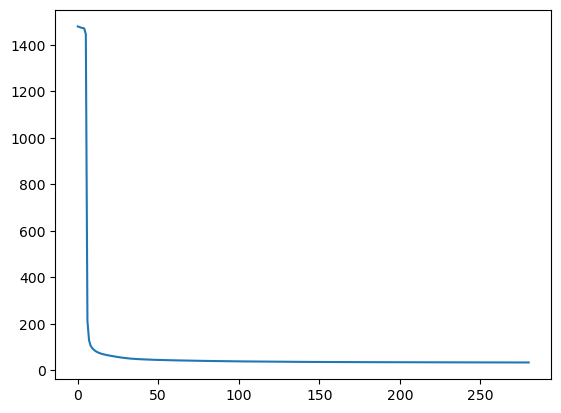

In [290]:
model.load_state_dict(best_weights)
print("MSE: %.3f" % best_mse)
print("RMSE: %.3f" % np.sqrt(best_mse))
print("MAPE: %.3f" % (100*best_mape))
plt.plot(history)
plt.show()

## Выводы

### Благодаря хорошему качеству Front End кода сайта krisha.kz нам удалось "спарсить" качественный набор данных для обучения модели.
### Лучший результат получился с применением логарифмирования целевой переменной и составил 8.79 по метрике MAPE.